In [1]:
import os
import mne # EEG Epochs
import pandas as pd # DataFrame
import matplotlib.pyplot as plt # Plot
import numpy as np # e.g. Arrays
from scipy import fftpack, signal # e.g. FFT, IIR filters, Welch's approximation for PSD
from scipy.integrate import simps # e.g. To compute absolute power 

### Import and read OpenBCI data

In [2]:
# Choose file
no_file = 1

# Get filepath
subfolder = 'OpenBCISession_2020-07-25_11-57-13/'

filename = ['OpenBCI-RAW-2020-07-25_11-57-51.txt', 
         'OpenBCI-RAW-2020-07-25_12-00-26.txt',
         'OpenBCI-RAW-2020-07-25_12-02-50.txt',
         'OpenBCI-RAW-2020-07-25_12-05-38.txt']

filepath = os.path.join(subfolder, filename[no_file])

# Read file and rename columns
eeg_data = pd.read_csv(filepath, skiprows=6)
eeg_data.columns = ['index','Fp2','CH2','CH3', 'CH4','CH5','CH6','CH7','CH8', 'Aux1', 'Aux2','Timestamp']

# Save as Pandas dataframe
eeg_dataframe = pd.DataFrame(eeg_data)
eeg_dataframe.drop(['index','CH2','CH3', 'CH4','CH5','CH6','CH7','CH8', 'Aux1', 'Aux2'], axis=1, inplace=True)

# Set time reference to 0 ms
eeg_dataframe['Timestamp'] = [float(data) - float(eeg_dataframe['Timestamp'][0]) for data in eeg_dataframe['Timestamp']]

# Set time in seconds
eeg_dataframe['Timestamp'] = np.divide(eeg_dataframe['Timestamp'], 1000)

eeg_dataframe

,Fp2,Timestamp
0,40292.82,0.000
1,39374.50,0.006
2,39836.60,0.006
3,40433.59,0.016
4,40796.20,0.016
...,...,...
34207,39096.42,136.619
34208,40009.53,136.625
34209,41036.21,136.625
34210,39642.02,136.633


In [3]:
# Constants
sampling_rate = 250.0 # assume OpenBCI sample rate
nyquist = sampling_rate/2.0
channel_name = 'Fp2'
data = eeg_dataframe[channel_name]
timestamp = eeg_dataframe['Timestamp']
signal_duration = eeg_dataframe['Timestamp'][len(timestamp)-1] - eeg_dataframe['Timestamp'][0]

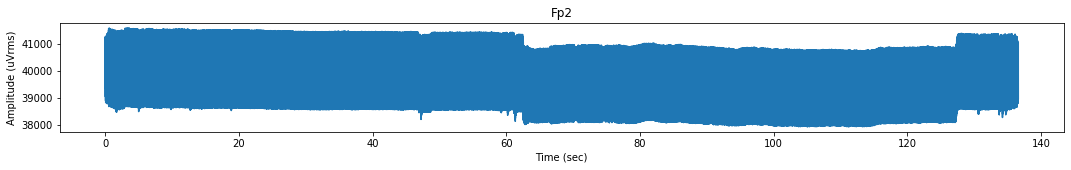

In [4]:
# Plot channel
plt.figure(figsize=(18, 2))
plt.title(channel_name)
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (uVrms)')
plt.plot(timestamp, data)

plt.show()

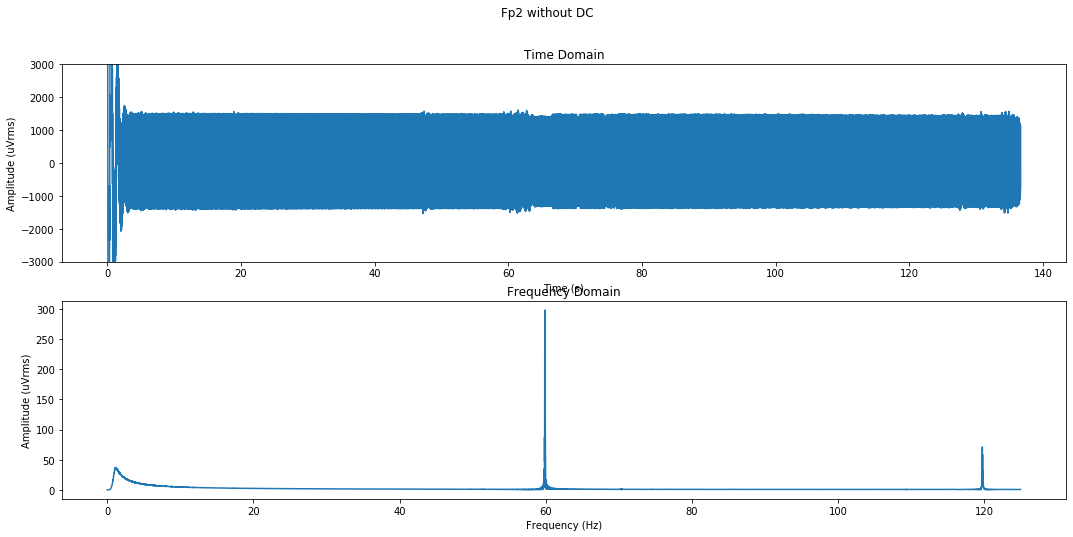

In [5]:
# Remove DC
b, a = signal.butter(5, 1.0/nyquist, 'highpass') # get coefficients
filtered_data = signal.lfilter(b, a, data, 0) # apply filter to signal

# Apply FFT
fourier = fftpack.fft(filtered_data)/len(filtered_data) # apply FFT
fourier = fourier[range(int(len(filtered_data)/2))] # remove sampling frequency

nb_samples = len(filtered_data)
values = np.arange(int(nb_samples/2))
period = nb_samples/sampling_rate
frequencies = values/period

# Plot
fig, axis = plt.subplots(2, figsize=[18,8])
fig.suptitle(channel_name + ' without DC')

axis[0].set_title('Time Domain')
axis[0].set_xlabel('Time (s)')
axis[0].set_ylabel('Amplitude (uVrms)')
axis[0].set_ylim([-3000,3000])
axis[0].plot(timestamp, filtered_data)

axis[1].set_title('Frequency Domain')
axis[1].set_xlabel('Frequency (Hz)')
axis[1].set_ylabel('Amplitude (uVrms)')
axis[1].plot(frequencies, abs(fourier))

plt.show()

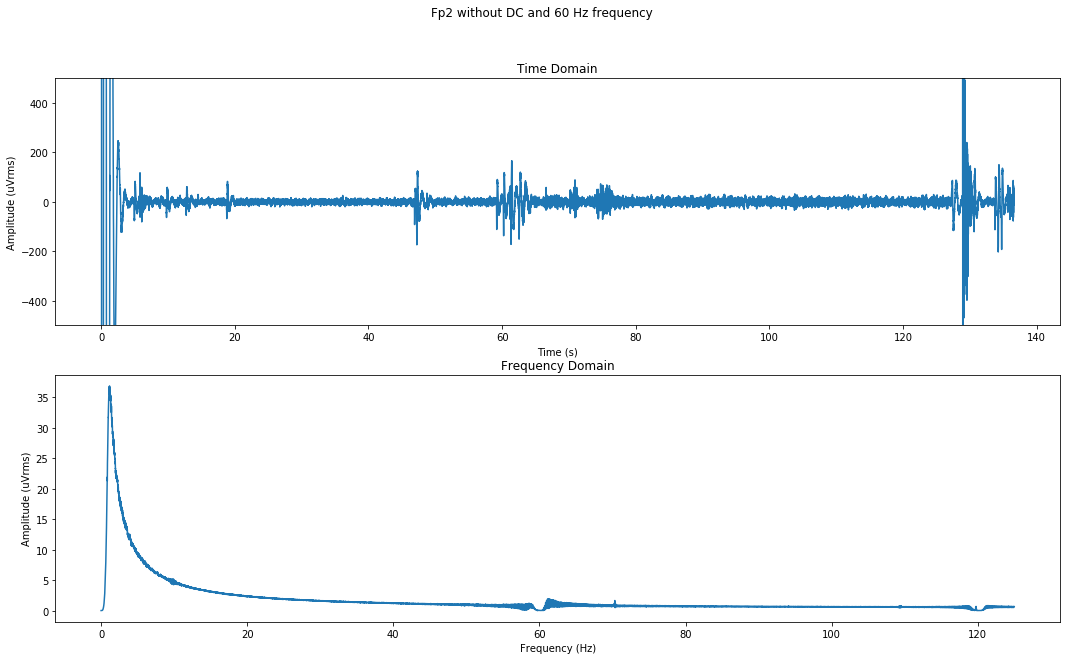

In [6]:
## Notch filters

# Remove 60 Hz
stop_filter_sx = np.array([59.0, 61.0])
b, a = signal.butter(4,stop_filter_sx/nyquist, 'bandstop')
filtered_data = signal.lfilter(b,a,filtered_data)

# Remove 120 Hz harmonic
stop_filter_harmonic = np.array([119.0, 121.0])
d, c = signal.butter(4,stop_filter_harmonic/nyquist, 'bandstop')
filtered_data = signal.lfilter(d,c,filtered_data)

# Apply FFT
fourier = fftpack.fft(filtered_data)/nb_samples # apply FFT
fourier = fourier[range(int(nb_samples/2))] # remove sampling frequency

## Plot
fig, axis = plt.subplots(2, figsize=[18,10])
fig.suptitle(channel_name + ' without DC and 60 Hz frequency')

axis[0].set_title('Time Domain') 
axis[0].set_xlabel('Time (s)')
axis[0].set_ylabel('Amplitude (uVrms)')
axis[0].set_ylim([-500,500])
axis[0].plot(timestamp, filtered_data)

axis[1].set_title('Frequency Domain')
axis[1].set_xlabel('Frequency (Hz)')
axis[1].set_ylabel('Amplitude (uVrms)')
axis[1].plot(frequencies, abs(fourier))

plt.show()

In [7]:
filt_eeg = pd.DataFrame(filtered_data)

processed_data_filename = "OpenBCISession_2020-07-25_11-57-13_processed_data/file_" + str(no_file) + "_" + str(channel_name) +".csv"
filt_eeg.to_csv(processed_data_filename)

### Divide signal into equal epochs

In [8]:
filepath_result = processed_data_filename
data = np.genfromtxt(filepath_result,delimiter=',')
data_channel = np.array([data[:,1]])
ch_types = ['eeg']
ch_names = [channel_name]

# create info object
info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp2
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 250.0 Hz
>

Creating RawArray with float64 data, n_channels=1, n_times=34213
    Range : 0 ... 34212 =      0.000 ...   136.848 secs
Ready.


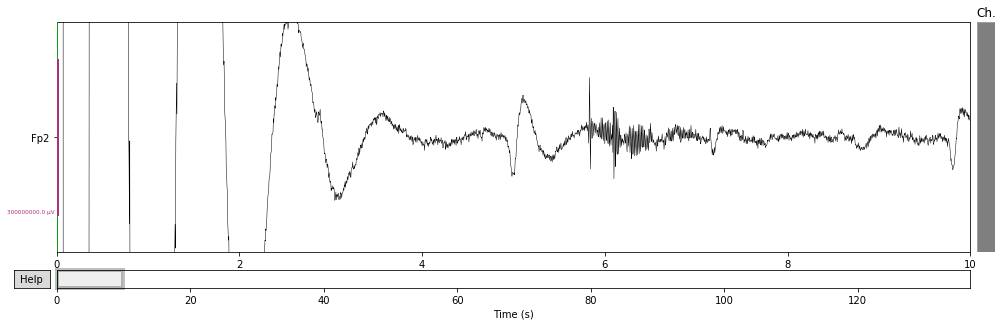

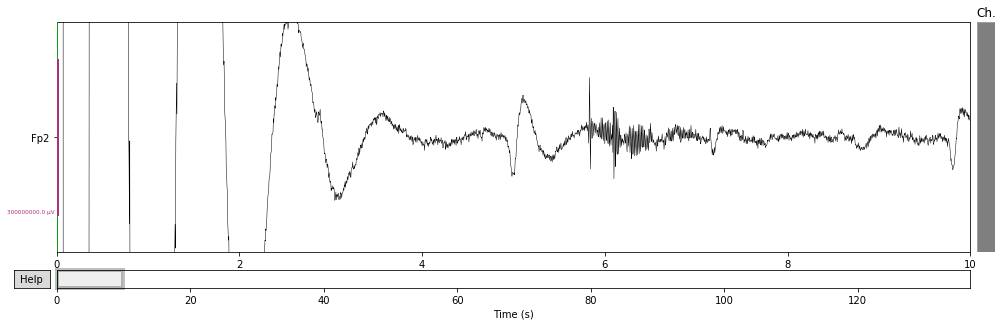

In [9]:
# create Raw object
raw = mne.io.RawArray(data_channel, info)

# uncomment following line to plot outside notebook:
# %matplotlib
raw.plot(n_channels=1, scalings=150)

Duration of each epoch: 9.759500000000001 s



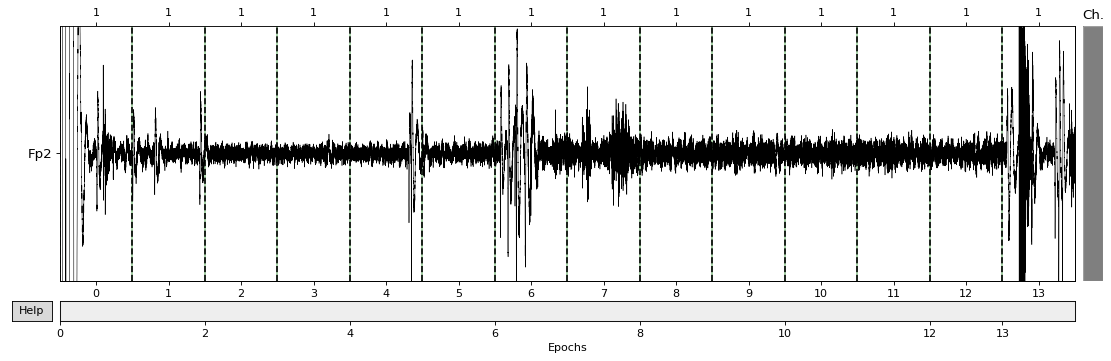

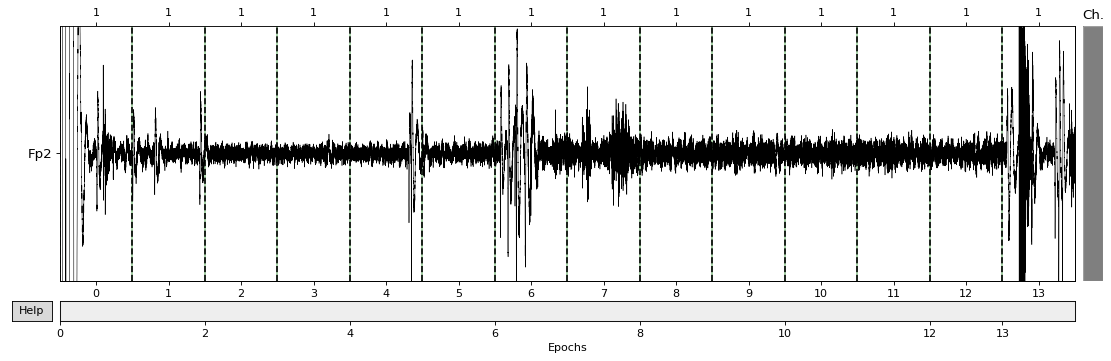

In [10]:
nb_total_epochs = 14
duration = signal_duration/nb_total_epochs

print('Duration of each epoch: ' + str(duration) + ' s\n')

epochs = mne.make_fixed_length_epochs(raw,duration=duration,verbose=False)
epochs.plot(scalings='auto')

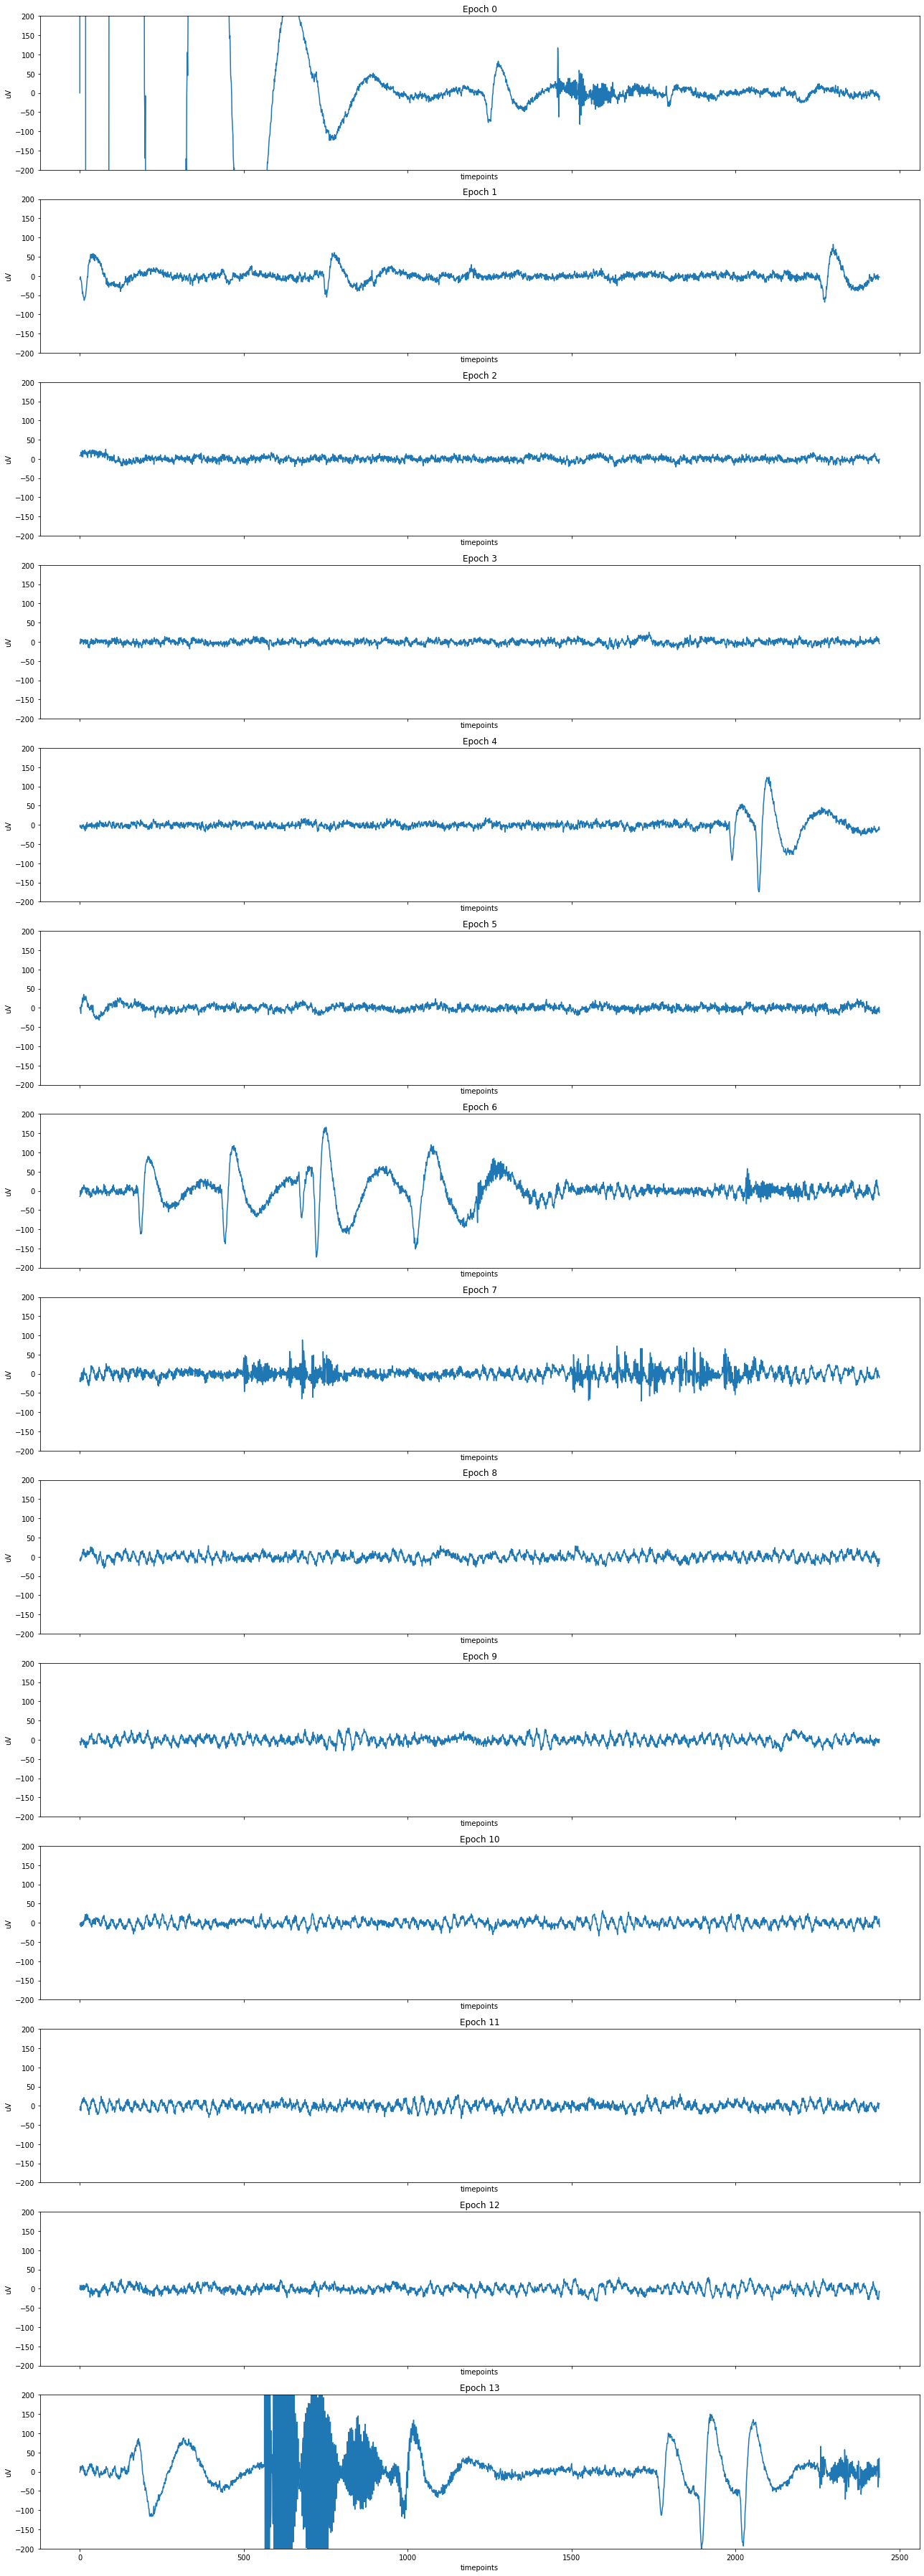

In [11]:
# uncomment following line to plot inside notebook
# %matplotlib inline

# plot each epoch independently
list_epochs = epochs.get_data() # get epoch data

fig, axis = plt.subplots(nrows=nb_total_epochs, figsize=[18,50],sharex=True)

for i in range(nb_total_epochs):
    axis[i].plot(range(len(list_epochs[i][0])),list_epochs[i][0])
    axis[i].set_title('Epoch ' + str(i))
    axis[i].set_ylabel('uV')
    axis[i].set_ylim([-200,200])
    axis[i].set_xlabel('timepoints')

plt.tight_layout()
plt.show()

### Drop bad epochs

In [12]:
epochs_to_drop = [0,6,13]
epochs.drop(epochs_to_drop, 'Too much noise', verbose=True)

Dropped 3 epochs: 0, 6, 13


<Epochs  |   11 events (all good), 0 - 9.756 sec, baseline off, ~7 kB, data not loaded,
 '1': 11>

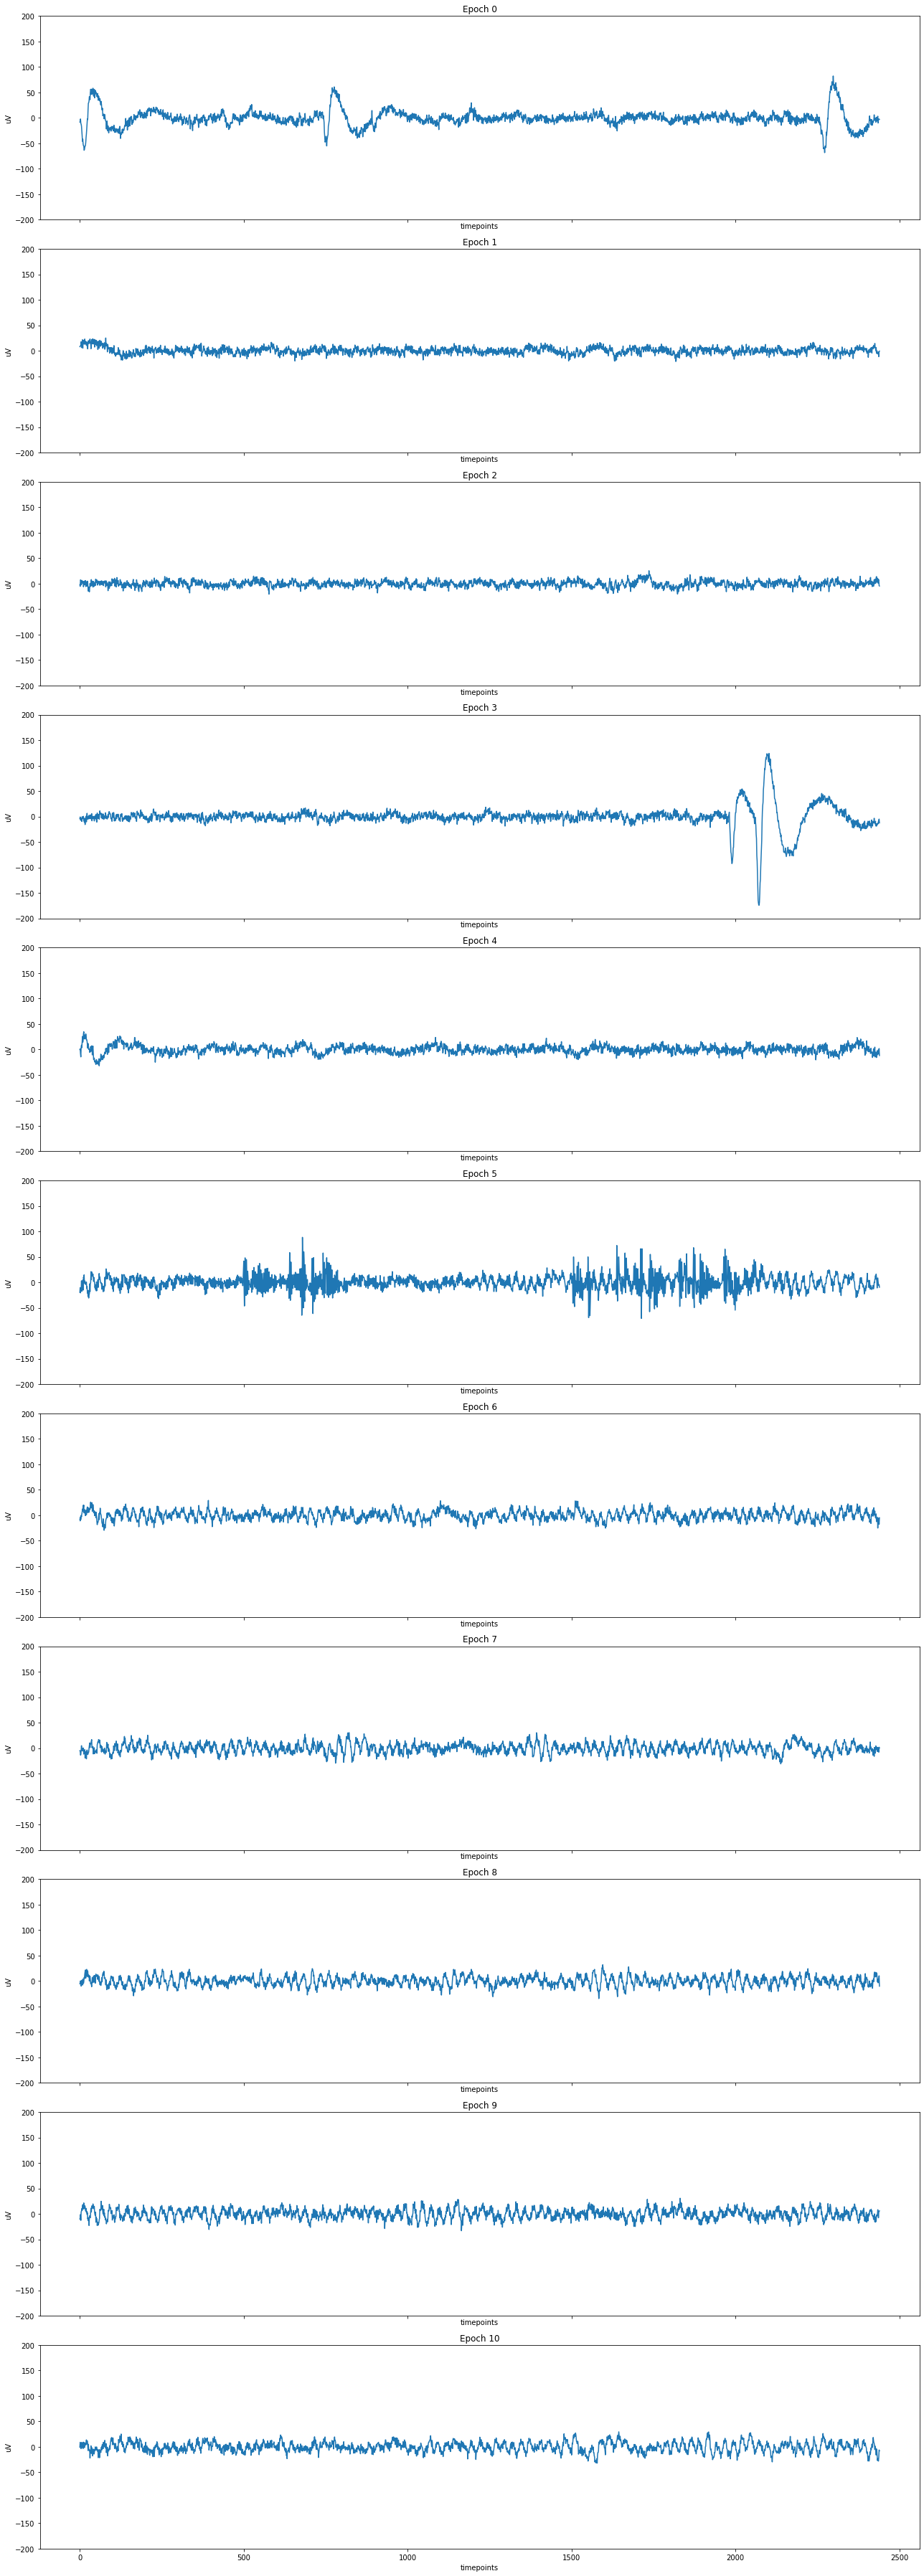

In [13]:
list_final_epochs = epochs.get_data() # get epoch data

fig, axis = plt.subplots(nrows=nb_total_epochs-len(epochs_to_drop), figsize=[18,50],sharex=True)

for i in range(nb_total_epochs-len(epochs_to_drop)):
    axis[i].plot(range(len(list_final_epochs[i][0])),list_final_epochs[i][0])
    axis[i].set_title('Epoch ' + str(i))
    axis[i].set_ylabel('uV')
    axis[i].set_ylim([-200,200])
    axis[i].set_xlabel('timepoints')

plt.tight_layout()
plt.show()

### Save epoch in an array

In [14]:
epochs_array = [ [], [], [], [], [], [], [], [], [], [], [] ] # one array per epoch

i = 0
while i < nb_total_epochs - len(epochs_to_drop):
    epochs_array[i] = list_final_epochs[i][0]
    i += 1

# Estimate Power Spectrum Density (PSD)
*Section based on this interesting article: https://raphaelvallat.com/bandpower.html*

Let's choose two epochs : first when eyes were opened (e.g. epoch 1) and second when eyes were closed (e.g. epoch 7)

In [15]:
first_epoch = 1
second_epoch = 7

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 3000 is greater than input length  = 2440, using nperseg = 2440
  .format(nperseg, input_length))


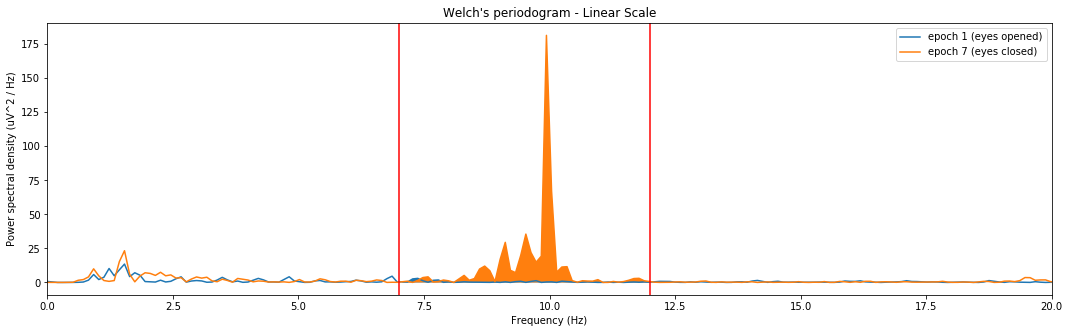

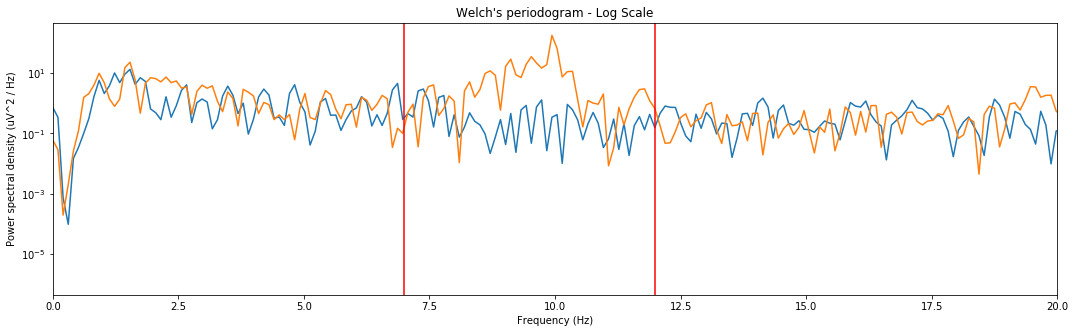

In [16]:
# Define alpha lower and upper limits
low, high = 7, 12

# plot on linear scale

plt.figure(figsize=[18,5])

window_size = high # arbitrary value

freq1, psd1 = signal.welch(epochs_array[first_epoch], sampling_rate, nperseg= window_size * sampling_rate)
plt.plot(freq1, psd1, label = 'epoch ' + str(first_epoch) + ' (eyes opened)')

freq2, psd2 = signal.welch(epochs_array[second_epoch], sampling_rate, nperseg= window_size * sampling_rate)
plt.plot(freq1, psd2, label = 'epoch ' + str(second_epoch) + ' (eyes closed)')

# Find intersecting values in frequency vector
idx_alpha = np.logical_and(freq1 >= low, freq1 <= high)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.title("Welch's periodogram - Linear Scale")
plt.xlim([0, 20])
plt.axvline(x=7, color='r')
plt.axvline(x=12, color='r')
plt.fill_between(freq1, psd1, where=idx_alpha)
plt.fill_between(freq2, psd2, where=idx_alpha)
plt.legend()
plt.show()

# plot on log scale

plt.figure(figsize=[18,5])

plt.plot(freq1, psd1)
plt.plot(freq1, psd2)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.title("Welch's periodogram - Log Scale")
plt.xlim([0, 20])
plt.axvline(x=7, color='r')
plt.axvline(x=12, color='r')
plt.yscale('log')
plt.show()

### Average of Alpha band power for each epoch

In [17]:
# Frequency resolution
freq_res_1 = freq1[1] - freq1[0]
freq_res_2 = freq2[1] - freq2[0]

# Absolute power = approximation of the area under the curve of Welch's periodogram
# between interval defined by 'idx_alpha'
alpha_power_1 = simps(psd1[idx_alpha], dx=freq_res_1) 
alpha_power_2 = simps(psd2[idx_alpha], dx=freq_res_2) 

print('Absolute alpha power eyes opened: ', round(alpha_power_1,2), 'uV^2/Hz')
print('Absolute alpha power eyes closed: ', round(alpha_power_2,2), 'uV^2/Hz')

Absolute alpha power eyes opened:  2.3 uV^2/Hz
Absolute alpha power eyes closed:  50.07 uV^2/Hz


In [18]:
# Relative alpha power 

# Total power = Total area under the curve of Welch periodogram
total_power_1 = simps(psd1, dx=freq_res_1)
alpha_rel_power_1 = alpha_power_1 / total_power_1 * 100

total_power_2 = simps(psd2, dx=freq_res_2)
alpha_rel_power_2 = alpha_power_2 / total_power_2 * 100

print('Relative alpha power when eyes opened: ', round(alpha_rel_power_1,2), '%')
print('Relative alpha power when eyes closed: ', round(alpha_rel_power_2,2), '%')

Relative alpha power when eyes opened:  6.12 %
Relative alpha power when eyes closed:  48.42 %


# Comparison between two epochs
Just a small test to visualize power spectrum of two selected epochs (eyes opened VS eyes closed)

In [19]:
nb_samples = len(epochs_array[0])
values = np.arange(int(nb_samples/2))
period = nb_samples/sampling_rate
frequencies = values/period

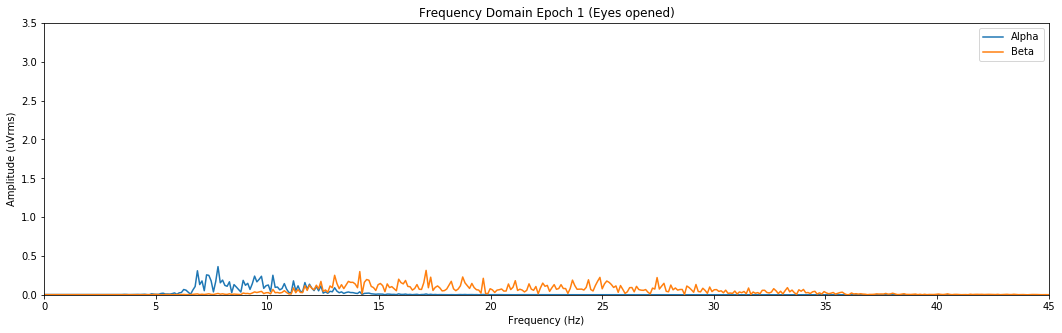

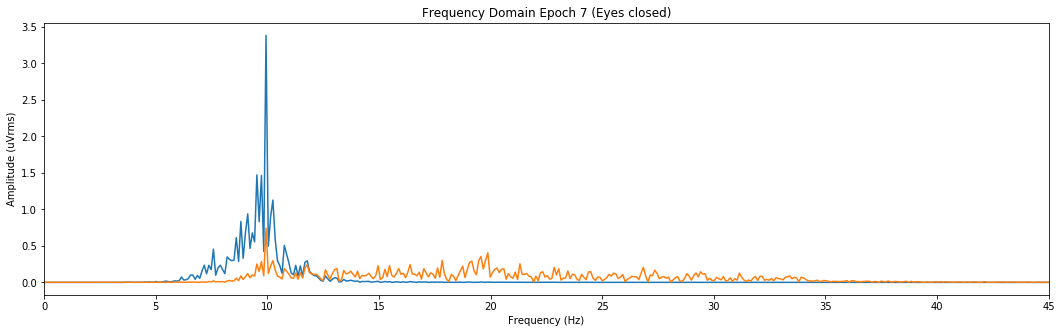

In [20]:
##### First epoch #####

# Create and Apply Alpha bandpass filter
alpha_range = np.array([7.0,12.0])
b, a = signal.butter(4,alpha_range/nyquist,'bandpass')
eeg_alpha_band = signal.lfilter(b,a,epochs_array[first_epoch],0)

# Apply FFT (alpha band)
fourier_alpha = fftpack.fft(eeg_alpha_band)/len(eeg_alpha_band)
fourier_alpha = fourier_alpha[range(int(len(fourier_alpha)/2))] # Remove sampling frequency

# Create and Apply Beta bandpass filter
beta_range = np.array([12.0,30.0])
d, c = signal.butter(4,beta_range/nyquist,'bandpass')
eeg_beta_band = signal.lfilter(d,c,epochs_array[first_epoch],0)

# Apply FFT (beta band)
fourier_beta = fftpack.fft(eeg_beta_band)/len(eeg_beta_band)
fourier_beta = fourier_beta[range(int(len(fourier_beta)/2))] # Remove sampling frequency

## - plot
plt.figure(figsize=[18,5])
plt.title('Frequency Domain Epoch ' + str(first_epoch) +' (Eyes opened)')
plt.ylim(0,3.5)
plt.xlim(0,45)
plt.ylabel('Amplitude (uVrms)')
plt.xlabel('Frequency (Hz)')
plt.plot(frequencies, abs(fourier_alpha), label='Alpha')
plt.plot(frequencies, abs(fourier_beta), label='Beta')
plt.legend()

plt.show()

##### Second epoch #####

# Create and Apply Alpha bandpass filter
b, a = signal.butter(4,alpha_range/nyquist,'bandpass')
eeg_alpha_band = signal.lfilter(b,a,epochs_array[second_epoch],0)

# Apply FFT (alpha band)
fourier_alpha = fftpack.fft(eeg_alpha_band)/len(eeg_alpha_band)
fourier_alpha = fourier_alpha[range(int(len(fourier_alpha)/2))] # Remove sampling frequency

# Create and Apply Beta bandpass filter
d, c = signal.butter(4,beta_range/nyquist,'bandpass')
eeg_beta_band = signal.lfilter(d,c,epochs_array[second_epoch],0)

# Apply FFT (beta band)
fourier_beta = fftpack.fft(eeg_beta_band)/len(eeg_beta_band)
fourier_beta = fourier_beta[range(int(len(fourier_beta)/2))] # Remove sampling frequency

## - plot
plt.figure(figsize=[18,5])
plt.title('Frequency Domain Epoch ' + str(second_epoch) + ' (Eyes closed)')
plt.xlim(0,45)
plt.ylabel('Amplitude (uVrms)')
plt.xlabel('Frequency (Hz)')
plt.plot(frequencies, abs(fourier_alpha))
plt.plot(frequencies, abs(fourier_beta))

plt.show()